# Import Libraries

In [3]:
import pandas as pd
import twitter
import yfinance as yf

# Load the Data

Tweets

In [ ]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
def print_progress_bar(index,total,day,month,year):
    n_bar = 50  
    progress = index / total
    sys.stdout.write('\r')
    sys.stdout.write(f"[{'=' * int(n_bar * progress):{n_bar}s}] {int(100 * progress)}% Tweets Retrived: {index+1} Running Date : {day}-{month}-{year}")
    sys.stdout.flush()

In [ ]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

for year in range(2022,2016,-1):
    print('Running Year : ',year-1)
    import snscrape.modules.twitter as sntwitter
    tweets_list2 = []
    total = 250000
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'sensex since:{year-1}-01-01 until:{year}-01-01').get_items()):
        if i>total:
            break
        tweets_list2.append([tweet.date,tweet.content])
        print_progress_bar(i,total,tweet.date.day,tweet.date.month,tweet.date.year)
    tweets_df2 = pd.DataFrame(tweets_list2, columns=['Datetime','Text'])
    tweets_df2.to_csv('Tweets_sensex_year'+str(year-1)+'.csv')

Google Trends

In [ ]:
from pytrends import dailydata

s_year = 2015
s_mon = 1
e_year = 2022
e_mon = 1

dailydata = dailydata.get_daily_data(word= 'sensex',
                 start_year= s_year,
                 start_mon= s_mon,
                 stop_year= e_year,
                 stop_mon= e_mon,
                 geo= '',
                 verbose= False,
                 wait_time = 5.0)

In [ ]:
dailydata.to_csv('google_trens_sensex.csv')

Yahoo! Finance

In [ ]:
data_bse = yf.download("^BSESN", start="2009-01-01", end="2022-01-01")

In [ ]:
data_bse.to_csv('sensex.csv')

Sentiment

# Pre-Processing

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def get_sentiment(sentence):
    tokenizer = RegexpTokenizer(r'\w+')
    stop_words = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer(r'\w+')
    word_tokens = tokenizer.tokenize(sentence)

    filtered_sentence = []

    for w in word_tokens:
        if w.lower() not in stop_words:
            filtered_sentence.append(w)
    
    sentence = ' '.join(filtered_sentence)
    
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    return sentiment_dict['compound']

# Gathering Sentiment Information

In [ ]:
frames = []
for year in range(2021,2016,-1):
    print('Running Year',year)
    df = pd.read_csv('Tweets_sensex_year'+str(year)+'.csv')
    sentiment = []
    for i,sentence in enumerate(df['Text']):
        sentiment.append(get_sentiment(sentence))
        print_progress_bar(i,len(df),0,0,0)
    df['sentiment'] = sentiment
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    frames.append(df.groupby([df['Datetime'].dt.date]).mean()[['sentiment']])
result = pd.concat(frames)
result.to_csv('tweet_sensex_sentiment.csv')

# Analysis

In [11]:
result = pd.read_csv('tweet_sensex_sentiment.csv',index_col="Datetime")
data_bse = pd.read_csv('sensex.csv',index_col='Date')
google_trends = pd.read_csv('google_trens_sensex.csv',index_col='date')

In [13]:
#Cover to datetime index
result.index = pd.to_datetime(result.index)
data_bse.index = pd.to_datetime(data_bse.index)
google_trends.index = pd.to_datetime(google_trends.index)

In [28]:
df1 = pd.DataFrame()
df1['sentiment'] = result['sentiment']
df1['google_trends'] = google_trends['sensex']
df1['close'] = data_bse['Close'].interpolate(method='time')
df1['close'] = df1['close'].interpolate(method='time')

In [32]:
df1 = df1.sort_index(ascending=True)

In [33]:
df1

,sentiment,google_trends,close
Datetime,,,
2017-01-01,0.324855,2.43,26595.449219
2017-01-02,0.199980,9.00,26595.449219
2017-01-03,0.285942,8.73,26643.240234
2017-01-04,0.311094,8.10,26633.130859
2017-01-05,0.364309,8.91,26878.240234
...,...,...,...
2021-12-27,0.327329,39.90,57420.238281
2021-12-28,0.379299,36.48,57897.480469
2021-12-29,0.303259,36.48,57806.488281


<AxesSubplot:title={'center':'Twitter Sentiment'}, xlabel='Datetime', ylabel='Sentiment'>

<Figure size 432x288 with 0 Axes>

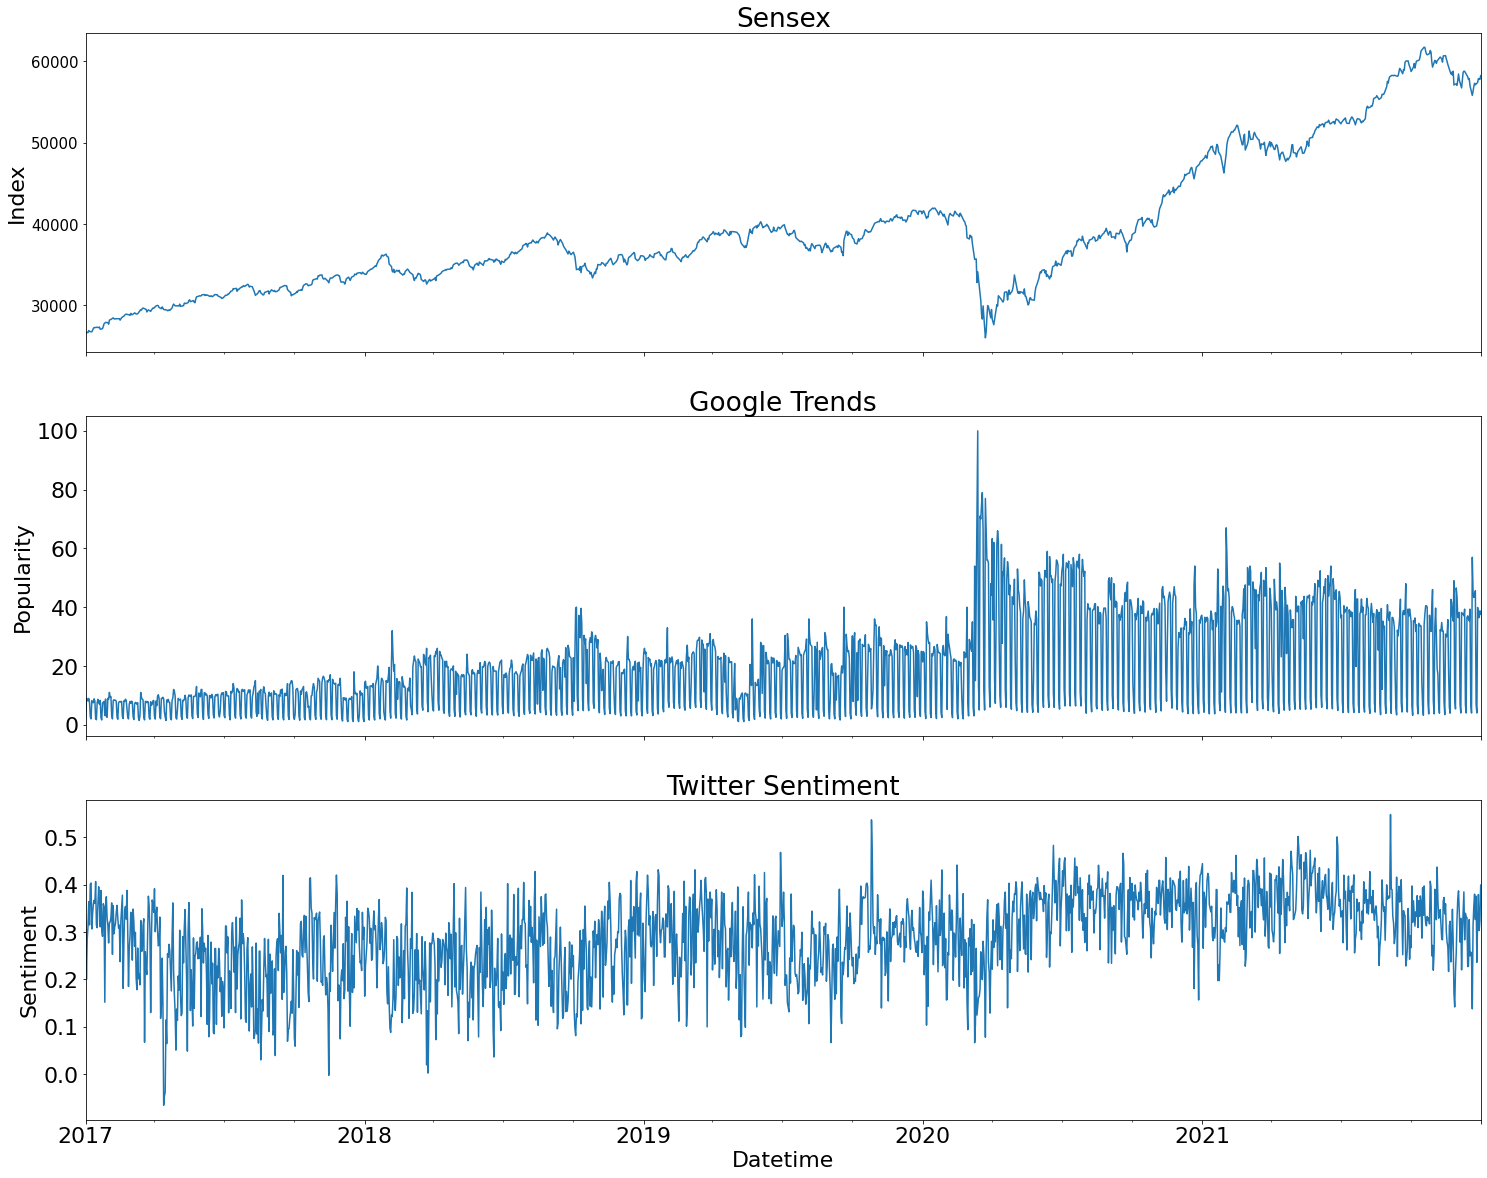

<Figure size 1080x720 with 0 Axes>

In [62]:
import matplotlib.pyplot as plt
plt.figure()
plt.rcParams.update({'font.size': 22})


fig, axes = plt.subplots(nrows=3, ncols=1)
plt.figure(figsize=(15,10))

df1[['close']].plot(ax=axes[0],figsize=(25, 20),ylabel='Index',sharex=True,fontsize=15,legend=False,title='Sensex')
df1[['google_trends']].plot(ax=axes[1],figsize=(25, 20),ylabel='Popularity',sharex=True,legend=False,title='Google Trends')
df1[['sentiment']].plot(ax=axes[2],figsize=(25, 20),ylabel='Sentiment',legend=False, title = 'Twitter Sentiment')

<AxesSubplot:>

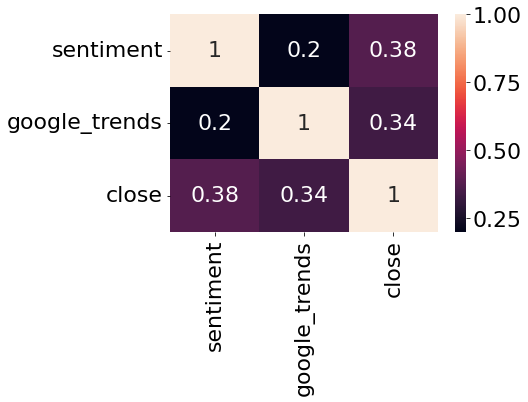

In [68]:
import seaborn as sns
sns.heatmap(df1.corr(),annot=True)

# Scaling

In [ ]:
scale_sent = (result['sentiment'] - result['sentiment'].min())/(result['sentiment'].max() - result['sentiment'].min())

In [ ]:
close = df1[['close']].interpolate(method='time').diff()

In [ ]:
close = (close-close.min())/(close.max()-close.min())

In [ ]:
import matplotlib.pyplot as plt
plt.plot(scale_sent[-100:],label='Sentiment')
plt.plot(close[-100:],label='Sensex Close')
plt.legend()

In [ ]:
df1.corr()

In [ ]:
close

In [ ]:
df1[['close']].plot()

In [ ]:
plt.plot(df1['close'])